In [22]:
# ====================================================================================
# CELL 1 – Imports & global settings
# ====================================================================================

import os, random, itertools, warnings, math, json, time, copy
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset, random_split
import torchvision.transforms as T
import torchvision.models as models


from torchvision.transforms import RandomApply, RandomAffine, RandomErasing


from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (8,6)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SEED   = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
print(f'Running on {DEVICE}')


Running on cpu


In [23]:
# ====================================================================================
# CELL 2 – Paths & transforms
# ====================================================================================

# Point to your un-zipped Kaggle copy of LFW
LFW_ROOT = Path(r"C:\Users\premy\.cache\kagglehub\datasets\jessicali9530\lfw-dataset\versions\4\lfw-deepfunneled\lfw")

assert LFW_ROOT.exists(), f"LFW directory not found: {LFW_ROOT}"


transform_train = T.Compose([
    T.Resize((224, 224)),
    T.RandomResizedCrop(224, scale=(0.7, 1.0), ratio=(0.8, 1.2)),
    T.RandomHorizontalFlip(0.5),
    T.RandomRotation(15),
    T.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.3, hue=0.12),
    RandomApply([T.GaussianBlur(3)], p=0.2),
    RandomApply([T.RandomGrayscale(p=1.0)], p=0.12),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225]),
    RandomErasing(p=0.35, scale=(0.02, 0.18), ratio=(0.3, 3.3), value='random')  # Cutout style
])


transform_test = T.Compose([
    T.Resize((224,224)),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])




In [24]:
# ====================================================================================
# CELL 3 – LFW single-image dataset
# ====================================================================================
from PIL import Image

class LFWDataset(Dataset):
    def __init__(self, root_dir:Path, transform=None):
        self.root_dir = Path(root_dir)
        self.transform = transform
        
        self.people = sorted([d.name for d in self.root_dir.iterdir() if d.is_dir()])
        self.image_paths, self.labels = [], []
        for idx, person in enumerate(self.people):
            for img_file in (self.root_dir/person).glob('*'):
                if img_file.suffix.lower() in {'.jpg','.jpeg','.png'}:
                    self.image_paths.append(img_file)
                    self.labels.append(idx)
        print(f'LFW: {len(self.image_paths)} images, {len(self.people)} identities')
    
    def __len__(self): return len(self.image_paths)
    
    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, self.labels[idx]


In [25]:
# ====================================================================================
# CELL 4 – Pair & triplet dataset helpers
# ====================================================================================

class SiamesePairs(Dataset):
    def __init__(self, base_ds:Dataset, num_pairs:int=5000):
        self.base_ds = base_ds
        self.num_pairs = num_pairs

        # group indices by label
        self.label_idx = {}
        for i, (_, lbl) in enumerate(base_ds):
            self.label_idx.setdefault(lbl, []).append(i)
        self.labels, self.pairs = [], []

        # Only use labels with at least 2 samples for positive pairs
        valid_labels = [lbl for lbl, idxs in self.label_idx.items() if len(idxs) >= 2]

        # positive pairs
        for _ in range(num_pairs // 2):
            if not valid_labels:
                break  # no way to generate more positive pairs
            lbl = random.choice(valid_labels)
            i1, i2 = random.sample(self.label_idx[lbl], 2)
            self.pairs.append((i1, i2)); self.labels.append(1)

        # negative pairs
        labels = list(self.label_idx.keys())
        for _ in range(num_pairs // 2):
            lbl1, lbl2 = random.sample(labels, 2)
            i1 = random.choice(self.label_idx[lbl1])
            i2 = random.choice(self.label_idx[lbl2])
            self.pairs.append((i1, i2)); self.labels.append(0)

    def __len__(self): return len(self.pairs)
    def __getitem__(self, idx):
        i1, i2 = self.pairs[idx]
        img1, _ = self.base_ds[i1]
        img2, _ = self.base_ds[i2]
        return img1, img2, torch.tensor(self.labels[idx], dtype=torch.float32)

class TripletSet(Dataset):
    def __init__(self, base_ds: Dataset, num_triplets: int = 5000):
        self.base_ds = base_ds
        self.triplets = []
        label_idx = {}

        # Group samples by label
        for i, (_, lbl) in enumerate(base_ds):
            label_idx.setdefault(lbl, []).append(i)
        
        # Filter labels with at least 2 samples (for anchor-positive)
        valid_labels = [lbl for lbl, idxs in label_idx.items() if len(idxs) >= 2]
        labels = list(label_idx.keys())

        if len(valid_labels) == 0:
            raise ValueError("No label has at least 2 samples to form anchor-positive pairs.")

        if len(labels) < 2:
            raise ValueError("Not enough distinct labels to form negative samples.")

        # Generate triplets
        while len(self.triplets) < num_triplets:
            a_lbl = random.choice(valid_labels)  # Anchor label with >=2 samples
            n_lbl_candidates = [l for l in labels if l != a_lbl]
            if not n_lbl_candidates:
                break  # no negatives to pick
            n_lbl = random.choice(n_lbl_candidates)

            a, p = random.sample(label_idx[a_lbl], 2)  # distinct anchor and positive
            n = random.choice(label_idx[n_lbl])        # negative

            self.triplets.append((a, p, n))

    def __len__(self):
        return len(self.triplets)

    def __getitem__(self, idx):
        a, p, n = self.triplets[idx]
        return self.base_ds[a][0], self.base_ds[p][0], self.base_ds[n][0]


In [26]:
# ====================================================================================
# CELL 5 – Backbone architectures
# ====================================================================================

import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

# 1.  MLP for 224×224 RGB images
class MLPBackbone(nn.Module):
    def __init__(self, emb_dim=128, input_size=224):  # smaller input size
        super().__init__()
        flattened_dim = input_size * input_size * 3
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flattened_dim, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(2048, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, emb_dim)
        )

    def forward(self, x):
        return F.normalize(self.net(x), p=2, dim=1)
# 2. simple CNN
class SimpleCNN(nn.Module):
    def __init__(self, emb_dim=128):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, 1, 1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, 1, 1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, 1, 1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, 1, 1), nn.BatchNorm2d(256), nn.ReLU(), nn.AdaptiveAvgPool2d(1)
        )
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(256, emb_dim)

    def forward(self, x):
        x = self.features(x).squeeze()
        x = self.dropout(x)
        return F.normalize(self.fc(x), p=2, dim=1)

# 3. Deep CNN (ResNet-18 pre-trained)
class DeepCNN(nn.Module):
    def __init__(self, emb_dim=128):
        super().__init__()
        self.backbone = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        self.backbone.fc = nn.Linear(self.backbone.fc.in_features, emb_dim)

    def forward(self, x):
        return F.normalize(self.backbone(x), p=2, dim=1)

# 4. MobileNetV2 pre-trained
class MobileNetBackbone(nn.Module):
    def __init__(self, emb_dim=128):
        super().__init__()
        self.backbone = models.mobilenet_v3_large(weights=models.MobileNet_V3_Large_Weights.DEFAULT)
        self.backbone.classifier = nn.Sequential(
            nn.Linear(self.backbone.classifier[0].in_features, emb_dim)
        )

    def forward(self, x):
        return F.normalize(self.backbone(x), p=2, dim=1)



In [27]:
# ====================================================================================
# CELL 6 – Loss functions
# ====================================================================================

class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0): super().__init__(); self.margin=margin
    def forward(self,z1,z2,y):
        d = F.pairwise_distance(z1,z2)
        return torch.mean(y*d.pow(2) + (1-y)*F.relu(self.margin-d).pow(2))

class TripletLoss(nn.Module):
    def __init__(self, margin=1.0): super().__init__(); self.margin=margin
    def forward(self,a,p,n):
        return torch.mean(F.relu(
            F.pairwise_distance(a,p) - F.pairwise_distance(a,n) + self.margin))

# Built-in PyTorch cosine embedding loss (expects targets 1/-1)
cos_emb_loss = nn.CosineEmbeddingLoss()

# Simple InfoNCE (assumes batch has positive pairs in consecutive rows)
class InfoNCELoss(nn.Module):
    def __init__(self, temperature=0.07): super().__init__(); self.t=temperature
    def forward(self, z):                 # z shape (2B, emb)
        B = z.shape[0]//2
        z = F.normalize(z, dim=1)
        sim = torch.mm(z, z.t())/self.t
        labels = torch.cat([torch.arange(B) for _ in range(2)],0).to(z.device)
        return F.cross_entropy(sim, labels)


In [28]:
# ====================================================================================
# CELL 7 – Siamese & Triplet wrappers
# ====================================================================================

class Siamese(nn.Module):
    def __init__(self, backbone): super().__init__(); self.backbone = backbone
    def forward(self,x1,x2): return self.backbone(x1), self.backbone(x2)
    def embed(self,x): return self.backbone(x)


In [29]:
# ====================================================================================
# CELL 8 – Training helpers
# ====================================================================================

def train_epoch_siam(model, loader, criterion, optimiser):
    model.train(); running=0
    for (x1,x2,y) in loader:
        x1,x2,y = x1.to(DEVICE),x2.to(DEVICE),y.to(DEVICE)
        optimiser.zero_grad()
        z1,z2 = model(x1,x2)
        loss = criterion(z1,z2,y)
        loss.backward(); optimiser.step()
        running += loss.item()*x1.size(0)
    return running/len(loader.dataset)

def train_epoch_triplet(model, loader, criterion, optimiser):
    model.train(); running=0
    for (a,p,n) in loader:
        a,p,n = a.to(DEVICE),p.to(DEVICE),n.to(DEVICE)
        optimiser.zero_grad()
        loss = criterion(model.embed(a), model.embed(p), model.embed(n))
        loss.backward(); optimiser.step()
        running += loss.item()*a.size(0)
    return running/len(loader.dataset)

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    sims, labels = [], []
    for x1,x2,y in loader:
        z1,z2 = model(x1.to(DEVICE),x2.to(DEVICE))
        sims.extend(F.cosine_similarity(z1,z2).cpu().numpy())
        labels.extend(y.numpy())
    sims = np.array(sims); labels=np.array(labels)
    auc = roc_auc_score(labels, sims)
    best_acc, best_th = 0,0
    for t in np.linspace(-1,1,200):
        acc = accuracy_score(labels, (sims>t).astype(int))
        if acc>best_acc: best_acc, best_th = acc,t
    return auc, best_acc, best_th


In [30]:
# ====================================================================================
# CELL 9 – t-SNE visualisation
# ====================================================================================
'''
def plot_tsne(model, dataset, n_samples=1000):
    model.eval()
    total = len(dataset)
    actual_n = min(n_samples, total)
    idxs = random.sample(range(total), actual_n)
    imgs = torch.stack([dataset[i][0] for i in idxs]).to(DEVICE)
    labels = np.array([dataset[i][1] for i in idxs])
    emb = model.embed(imgs).cpu().numpy()
    emb = StandardScaler().fit_transform(emb)
    tsne = TSNE(n_components=2, init='random', learning_rate='auto',
                perplexity=30, max_iter=1000, random_state=SEED).fit_transform(emb)
    plt.figure(figsize=(7,7))
    scatter = plt.scatter(tsne[:,0], tsne[:,1], c=labels, cmap='tab20', s=8)
    plt.title('t-SNE embeddings'); plt.axis('off')
'''

from torch.utils.data import DataLoader, Subset

@torch.no_grad()
def plot_tsne(model, dataset, n_samples=500):
    idxs = np.random.choice(len(dataset), size=n_samples, replace=False)
    subset = Subset(dataset, idxs)
    loader = DataLoader(subset, batch_size=64, shuffle=False)

    model.eval()
    all_embs, all_labels = [], []

    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(DEVICE)
            emb = model.embed(imgs).cpu()
            all_embs.append(emb)
            all_labels.extend(labels.numpy())

    emb = torch.cat(all_embs).numpy()
    emb = StandardScaler().fit_transform(emb)

    tsne = TSNE(n_components=2, init='random', learning_rate='auto',
                perplexity=30, max_iter=1000, random_state=42).fit_transform(emb)

    # Plot
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(tsne[:, 0], tsne[:, 1], c=all_labels, cmap='tab20', alpha=0.7)
    plt.title('t-SNE Embeddings')
    plt.colorbar(scatter)
    return plt.gcf()

In [31]:
# ====================================================================================
# CELL 10 – Data preparation (train/test split & loaders)
# ====================================================================================

full_ds = LFWDataset(LFW_ROOT, transform=transform_train)
train_size = int(0.8*len(full_ds))
test_size  = len(full_ds)-train_size
train_base, test_base = random_split(full_ds,[train_size,test_size])

train_pairs = SiamesePairs(train_base, num_pairs=300)
test_pairs  = SiamesePairs(test_base,  num_pairs=150)
train_trip  = TripletSet(train_base,   num_triplets=300)

BATCH = 32
train_loader_pairs = DataLoader(train_pairs, batch_size=BATCH, shuffle=True)
test_loader_pairs  = DataLoader(test_pairs,  batch_size=BATCH)
train_loader_trip  = DataLoader(train_trip,  batch_size=BATCH, shuffle=True)


LFW: 13233 images, 5749 identities


In [32]:
from collections import Counter

label_counts = Counter([lbl for _, lbl in train_base])
num_labels_2plus = sum(1 for c in label_counts.values() if c >= 2)
print(f"Number of labels with at least 2 images: {num_labels_2plus}")

import pandas as pd

Number of labels with at least 2 images: 1395



=== MLP + Contrastive ===
Epoch 1: loss 0.3213
Epoch 2: loss 0.2605
Epoch 3: loss 0.2531
Epoch 4: loss 0.2513
Epoch 5: loss 0.2379
→ AUC 0.668 | Acc 0.647 @ thr 0.91

=== MLP + Cosine ===
Epoch 1: loss 0.4843
Epoch 2: loss 0.4526
Epoch 3: loss 0.4577
Epoch 4: loss 0.4492
Epoch 5: loss 0.4497
→ AUC 0.525 | Acc 0.553 @ thr 0.23

=== MLP + InfoNCE ===
Epoch 1: loss 3.4372
Epoch 2: loss 3.1637
Epoch 3: loss 3.0750
Epoch 4: loss 2.9401
Epoch 5: loss 2.9529
→ AUC 0.531 | Acc 0.547 @ thr 0.65

=== MLP + Triplet ===
Epoch 1: loss 0.9724
Epoch 2: loss 0.9311
Epoch 3: loss 0.9529
Epoch 4: loss 0.9547
Epoch 5: loss 0.8855


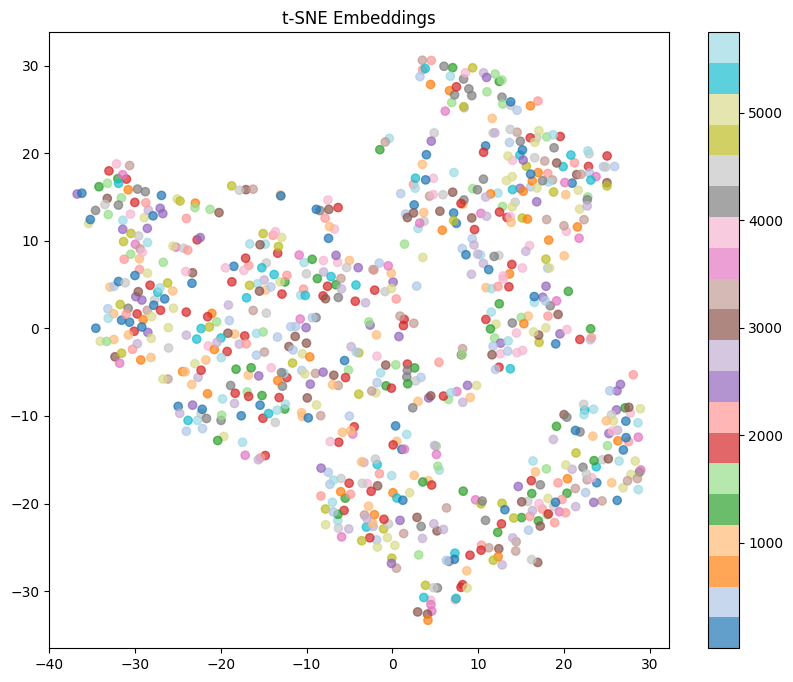

  Arch         Loss    AUC    Acc  Threshold
0  MLP  Contrastive  0.668  0.647      0.910
1  MLP       Cosine  0.525  0.553      0.226
2  MLP      InfoNCE  0.531  0.547      0.648
3  MLP      Triplet  0.602  0.587     -0.095


In [33]:
import pandas as pd
# ====================================================================================
# CELL 1 – MLP experiments
# ====================================================================================
arch_name = 'MLP'
Arch = MLPBackbone

loss_funcs = {
    'Contrastive': ContrastiveLoss(),
    'Cosine':      lambda z1,z2,y: cos_emb_loss(z1,z2,(2*y-1)),
    'InfoNCE':     InfoNCELoss(),
}

results = []

for loss_name, loss_fn in loss_funcs.items():
    print(f'\n=== {arch_name} + {loss_name} ===')
    model = Siamese(Arch().to(DEVICE))
    opt = optim.Adam(model.parameters(), lr=1e-3)

    if loss_name == 'InfoNCE':
        def epoch():
            model.train(); running = 0
            for x1, x2, _ in train_loader_pairs:
                x = torch.cat([x1, x2], 0).to(DEVICE)
                opt.zero_grad()
                loss = loss_fn(model.embed(x))
                loss.backward(); opt.step()
                running += loss.item() * x1.size(0)
            return running / len(train_loader_pairs.dataset)
        train_fn = epoch
    else:
        train_fn = lambda: train_epoch_siam(model, train_loader_pairs, loss_fn, opt)

    for ep in range(5):
        l = train_fn(); print(f'Epoch {ep+1}: loss {l:.4f}')
    auc, acc, th = evaluate(model, test_loader_pairs)
    print(f'→ AUC {auc:.3f} | Acc {acc:.3f} @ thr {th:.2f}')
    results.append(dict(Arch=arch_name, Loss=loss_name, AUC=auc, Acc=acc, Threshold=th))

# Triplet loss
print(f'\n=== {arch_name} + Triplet ===')
model = Siamese(Arch().to(DEVICE))
opt = optim.Adam(model.parameters(), lr=1e-3)
for ep in range(5):
    l = train_epoch_triplet(model, train_loader_trip, TripletLoss(), opt)
    print(f'Epoch {ep+1}: loss {l:.4f}')
auc, acc, th = evaluate(model, test_loader_pairs)
results.append(dict(Arch=arch_name, Loss='Triplet', AUC=auc, Acc=acc, Threshold=th))
plot_tsne(model, test_base, min(800, len(test_base))); plt.show()

torch.save(model.state_dict(), 'model_epoch_%d.pth' % (ep+1))
df = pd.DataFrame(results).round(3)
print(df)

df.to_csv('s_arch_loss_results.csv', index=False)



=== SimpleCNN + Contrastive ===
Epoch 1: loss 0.2890
Epoch 2: loss 0.2498
Epoch 3: loss 0.2548
Epoch 4: loss 0.2444
Epoch 5: loss 0.2449
→ AUC 0.506 | Acc 0.533 @ thr 0.93

=== SimpleCNN + Cosine ===
Epoch 1: loss 0.4970
Epoch 2: loss 0.4938
Epoch 3: loss 0.4674
Epoch 4: loss 0.4855
Epoch 5: loss 0.4689
→ AUC 0.506 | Acc 0.540 @ thr 0.47

=== SimpleCNN + InfoNCE ===
Epoch 1: loss 3.0792
Epoch 2: loss 2.9637
Epoch 3: loss 2.9083
Epoch 4: loss 2.9005
Epoch 5: loss 2.9046
→ AUC 0.526 | Acc 0.573 @ thr 0.91

=== SimpleCNN + Triplet ===
Epoch 1: loss 0.9792
Epoch 2: loss 0.9930
Epoch 3: loss 0.9520
Epoch 4: loss 0.9711
Epoch 5: loss 0.9657


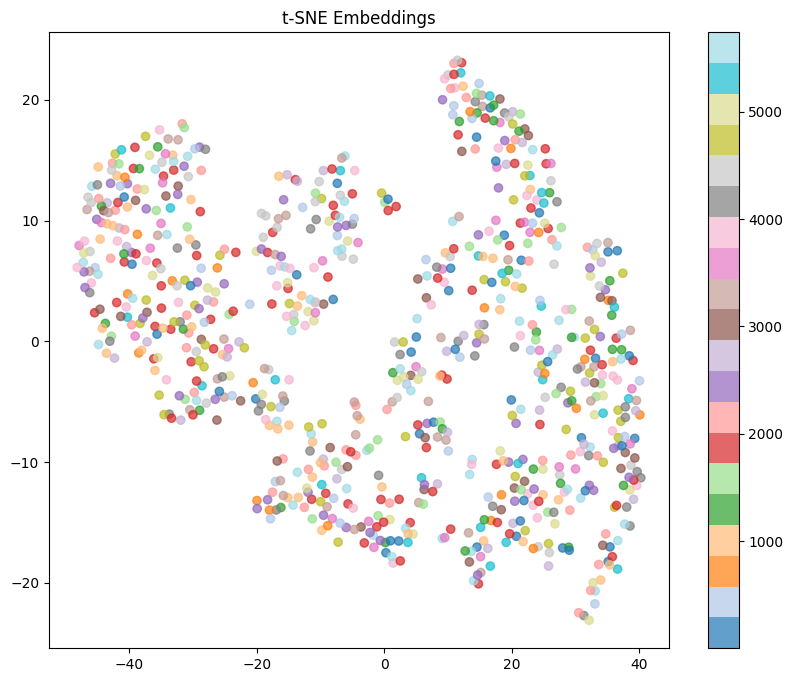

In [34]:
# ====================================================================================
# CELL 2 – SimpleCNN experiments
# ====================================================================================
arch_name = 'SimpleCNN'
Arch = SimpleCNN

for loss_name, loss_fn in loss_funcs.items():
    print(f'\n=== {arch_name} + {loss_name} ===')
    model = Siamese(Arch().to(DEVICE))
    opt = optim.Adam(model.parameters(), lr=1e-3)

    if loss_name == 'InfoNCE':
        def epoch():
            model.train(); running = 0
            for x1, x2, _ in train_loader_pairs:
                x = torch.cat([x1, x2], 0).to(DEVICE)
                opt.zero_grad()
                loss = loss_fn(model.embed(x))
                loss.backward(); opt.step()
                running += loss.item() * x1.size(0)
            return running / len(train_loader_pairs.dataset)
        train_fn = epoch
    else:
        train_fn = lambda: train_epoch_siam(model, train_loader_pairs, loss_fn, opt)

    for ep in range(5):
        l = train_fn(); print(f'Epoch {ep+1}: loss {l:.4f}')
    auc, acc, th = evaluate(model, test_loader_pairs)
    print(f'→ AUC {auc:.3f} | Acc {acc:.3f} @ thr {th:.2f}')
    results.append(dict(Arch=arch_name, Loss=loss_name, AUC=auc, Acc=acc, Threshold=th))

print(f'\n=== {arch_name} + Triplet ===')
model = Siamese(Arch().to(DEVICE))
opt = optim.Adam(model.parameters(), lr=1e-3)
for ep in range(5):
    l = train_epoch_triplet(model, train_loader_trip, TripletLoss(), opt)
    print(f'Epoch {ep+1}: loss {l:.4f}')
auc, acc, th = evaluate(model, test_loader_pairs)
results.append(dict(Arch=arch_name, Loss='Triplet', AUC=auc, Acc=acc, Threshold=th))
plot_tsne(model, test_base, min(800, len(test_base))); plt.show()

torch.save(model.state_dict(), 'model_epoch_%d.pth' % (ep+1))


In [35]:
df = pd.DataFrame(results).round(3)

df.to_csv('s_arch_loss_results.csv', index=False)



=== DeepCNN_resnet50 + Contrastive ===
Epoch 1: loss 0.3135
Epoch 2: loss 0.2416
Epoch 3: loss 0.2332
Epoch 4: loss 0.2253
Epoch 5: loss 0.2324
→ AUC 0.505 | Acc 0.540 @ thr 0.92

=== DeepCNN_resnet50 + Cosine ===
Epoch 1: loss 0.5142
Epoch 2: loss 0.4712
Epoch 3: loss 0.4078
Epoch 4: loss 0.4534
Epoch 5: loss 0.4870
→ AUC 0.532 | Acc 0.547 @ thr -0.18

=== DeepCNN_resnet50 + InfoNCE ===
Epoch 1: loss 3.6005
Epoch 2: loss 2.9265
Epoch 3: loss 2.8051
Epoch 4: loss 2.7160
Epoch 5: loss 2.6341
→ AUC 0.669 | Acc 0.647 @ thr 0.73

=== DeepCNN_resnet50 + Triplet ===
Epoch 1: loss 0.9183


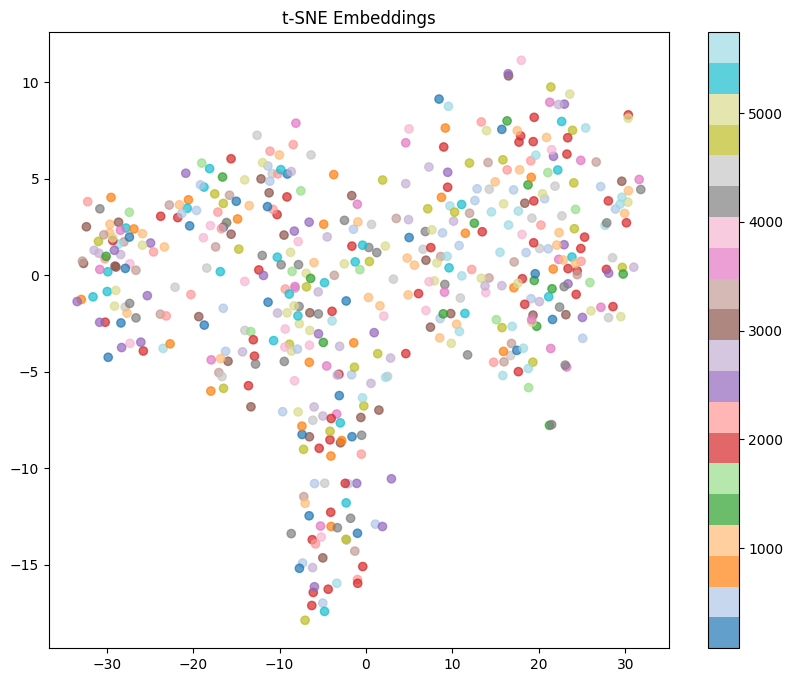

In [36]:
# ====================================================================================
# CELL 3 – DeepCNN experiments
# ====================================================================================
arch_name = 'DeepCNN_resnet50'
Arch = DeepCNN

for loss_name, loss_fn in loss_funcs.items():
    print(f'\n=== {arch_name} + {loss_name} ===')
    model = Siamese(Arch().to(DEVICE))
    opt = optim.Adam(model.parameters(), lr=1e-3)

    if loss_name == 'InfoNCE':
        def epoch():
            model.train(); running = 0
            for x1, x2, _ in train_loader_pairs:
                x = torch.cat([x1, x2], 0).to(DEVICE)
                opt.zero_grad()
                loss = loss_fn(model.embed(x))
                loss.backward(); opt.step()
                running += loss.item() * x1.size(0)
            return running / len(train_loader_pairs.dataset)
        train_fn = epoch
    else:
        train_fn = lambda: train_epoch_siam(model, train_loader_pairs, loss_fn, opt)

    for ep in range(5):
        l = train_fn(); print(f'Epoch {ep+1}: loss {l:.4f}')
    auc, acc, th = evaluate(model, test_loader_pairs)
    print(f'→ AUC {auc:.3f} | Acc {acc:.3f} @ thr {th:.2f}')
    results.append(dict(Arch=arch_name, Loss=loss_name, AUC=auc, Acc=acc, Threshold=th))

print(f'\n=== {arch_name} + Triplet ===')
model = Siamese(Arch().to(DEVICE))
opt = optim.Adam(model.parameters(), lr=1e-3)
for ep in range(1):
    l = train_epoch_triplet(model, train_loader_trip, TripletLoss(), opt)
    print(f'Epoch {ep+1}: loss {l:.4f}')
auc, acc, th = evaluate(model, test_loader_pairs)
results.append(dict(Arch=arch_name, Loss='Triplet', AUC=auc, Acc=acc, Threshold=th))
plot_tsne(model, test_base, min(500, len(test_base))); plt.show()


torch.save(model.state_dict(), 'model_epoch_%d.pth' % (ep+1))
df = pd.DataFrame(results).round(3)

df.to_csv('s_arch_loss_results.csv', index=False)


In [37]:

print(df)


                Arch         Loss    AUC    Acc  Threshold
0                MLP  Contrastive  0.668  0.647      0.910
1                MLP       Cosine  0.525  0.553      0.226
2                MLP      InfoNCE  0.531  0.547      0.648
3                MLP      Triplet  0.602  0.587     -0.095
4          SimpleCNN  Contrastive  0.506  0.533      0.930
5          SimpleCNN       Cosine  0.506  0.540      0.467
6          SimpleCNN      InfoNCE  0.526  0.573      0.910
7          SimpleCNN      Triplet  0.592  0.580      0.206
8   DeepCNN_resnet50  Contrastive  0.505  0.540      0.920
9   DeepCNN_resnet50       Cosine  0.532  0.547     -0.176
10  DeepCNN_resnet50      InfoNCE  0.669  0.647      0.729
11  DeepCNN_resnet50      Triplet  0.648  0.633      0.075



=== MobileNetV3 + Contrastive ===
Epoch 1: loss 0.3034
Epoch 2: loss 0.2133
Epoch 3: loss 0.1690
Epoch 4: loss 0.1495
Epoch 5: loss 0.1362
→ AUC 0.804 | Acc 0.747 @ thr 0.92

=== MobileNetV3 + Cosine ===
Epoch 1: loss 0.4469
Epoch 2: loss 0.4247
Epoch 3: loss 0.3522
Epoch 4: loss 0.3708
Epoch 5: loss 0.2956
→ AUC 0.708 | Acc 0.653 @ thr 0.68

=== MobileNetV3 + InfoNCE ===
Epoch 1: loss 3.1901
Epoch 2: loss 2.6618
Epoch 3: loss 2.5378
Epoch 4: loss 2.3651
Epoch 5: loss 2.1828
→ AUC 0.803 | Acc 0.727 @ thr 0.81

=== MobileNetV3 + Triplet ===
Epoch 1: loss 0.8503
Epoch 2: loss 0.5387
Epoch 3: loss 0.4206
Epoch 4: loss 0.3659
Epoch 5: loss 0.3001


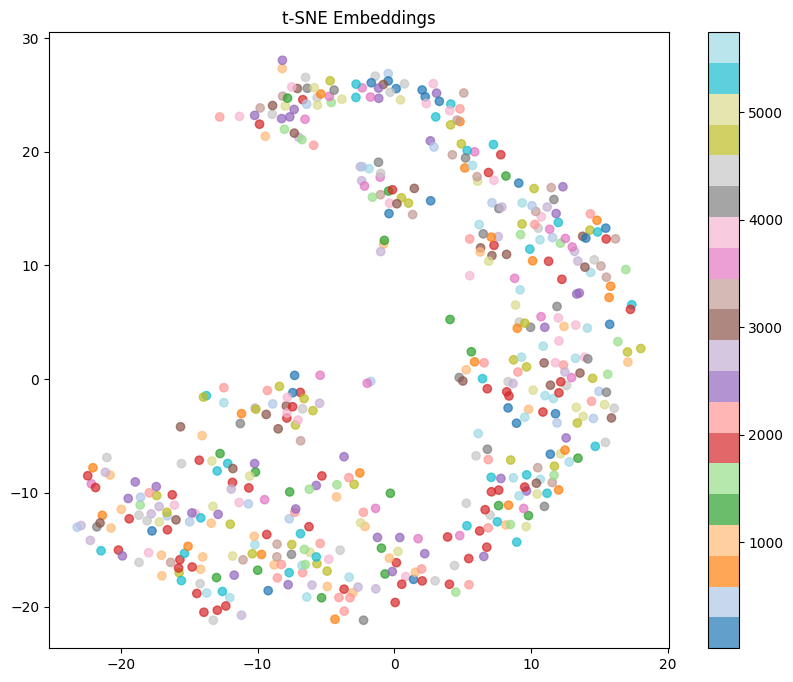

In [38]:
# ====================================================================================
# CELL 4 – MobileNetV2 experiments
# ====================================================================================
arch_name = 'MobileNetV3'
Arch = MobileNetBackbone

for loss_name, loss_fn in loss_funcs.items():
    print(f'\n=== {arch_name} + {loss_name} ===')
    model = Siamese(Arch().to(DEVICE))
    opt = optim.Adam(model.parameters(), lr=1e-3)

    if loss_name == 'InfoNCE':
        def epoch():
            model.train(); running = 0
            for x1, x2, _ in train_loader_pairs:
                x = torch.cat([x1, x2], 0).to(DEVICE)
                opt.zero_grad()
                loss = loss_fn(model.embed(x))
                loss.backward(); opt.step()
                running += loss.item() * x1.size(0)
            return running / len(train_loader_pairs.dataset)
        train_fn = epoch
    else:
        train_fn = lambda: train_epoch_siam(model, train_loader_pairs, loss_fn, opt)

    for ep in range(5):
        l = train_fn(); print(f'Epoch {ep+1}: loss {l:.4f}')
    auc, acc, th = evaluate(model, test_loader_pairs)
    print(f'→ AUC {auc:.3f} | Acc {acc:.3f} @ thr {th:.2f}')
    results.append(dict(Arch=arch_name, Loss=loss_name, AUC=auc, Acc=acc, Threshold=th))

print(f'\n=== {arch_name} + Triplet ===')
model = Siamese(Arch().to(DEVICE))
opt = optim.Adam(model.parameters(), lr=1e-3)
for ep in range(5):
    l = train_epoch_triplet(model, train_loader_trip, TripletLoss(), opt)
    print(f'Epoch {ep+1}: loss {l:.4f}')
auc, acc, th = evaluate(model, test_loader_pairs)
results.append(dict(Arch=arch_name, Loss='Triplet', AUC=auc, Acc=acc, Threshold=th))
plot_tsne(model, test_base, min(500, len(test_base))); plt.show()


torch.save(model.state_dict(), 'model_epoch_%d.pth' % (ep+1))


In [40]:
df = pd.DataFrame(results).round(3)
print(df)

df.to_csv('siamese_arch_loss_results.csv', index=False)


                Arch         Loss    AUC    Acc  Threshold
0                MLP  Contrastive  0.668  0.647      0.910
1                MLP       Cosine  0.525  0.553      0.226
2                MLP      InfoNCE  0.531  0.547      0.648
3                MLP      Triplet  0.602  0.587     -0.095
4          SimpleCNN  Contrastive  0.506  0.533      0.930
5          SimpleCNN       Cosine  0.506  0.540      0.467
6          SimpleCNN      InfoNCE  0.526  0.573      0.910
7          SimpleCNN      Triplet  0.592  0.580      0.206
8   DeepCNN_resnet50  Contrastive  0.505  0.540      0.920
9   DeepCNN_resnet50       Cosine  0.532  0.547     -0.176
10  DeepCNN_resnet50      InfoNCE  0.669  0.647      0.729
11  DeepCNN_resnet50      Triplet  0.648  0.633      0.075
12       MobileNetV3  Contrastive  0.804  0.747      0.920
13       MobileNetV3       Cosine  0.708  0.653      0.678
14       MobileNetV3      InfoNCE  0.803  0.727      0.809
15       MobileNetV3      Triplet  0.837  0.793      0.6

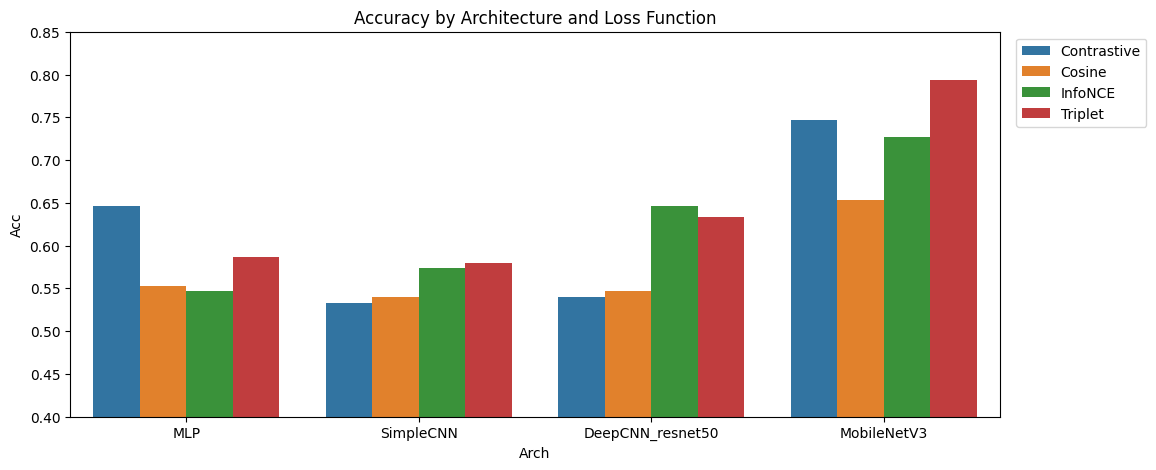

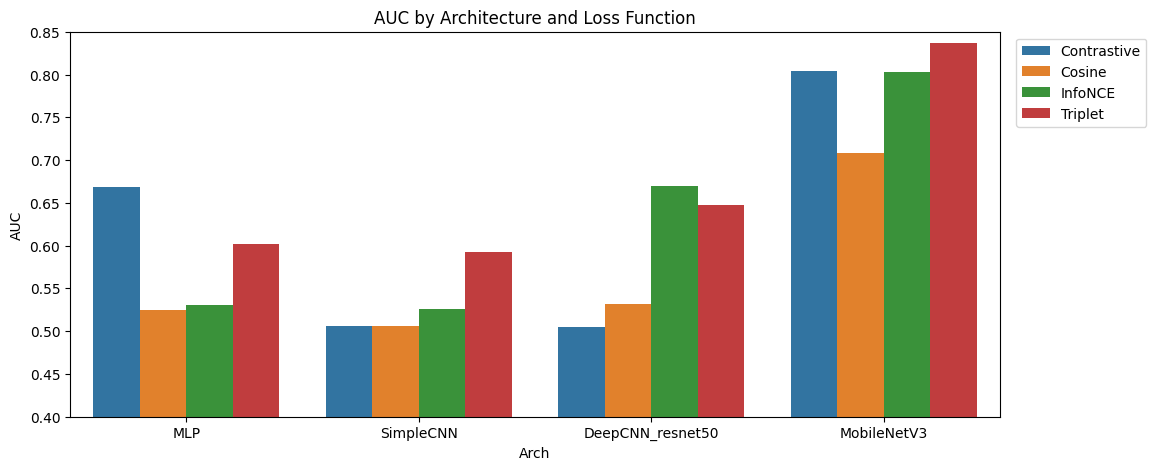

In [41]:
# ====================================================================================
# CELL 5 – Final Results Visualization
# ====================================================================================
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert results to DataFrame
df_results = pd.DataFrame(results)

# Plot Accuracy and AUC by Arch/Loss
plt.figure(figsize=(12, 5))
sns.barplot(data=df_results, x='Arch', y='Acc', hue='Loss')
plt.title('Accuracy by Architecture and Loss Function')
plt.ylim(0.4, 0.85)
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.show()

plt.figure(figsize=(12, 5))
sns.barplot(data=df_results, x='Arch', y='AUC', hue='Loss')
plt.title('AUC by Architecture and Loss Function')
plt.ylim(0.4, 0.85)
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.show()


In [49]:
def show_pair_prediction(model, dataset, threshold=0.5):
    model.eval()
    for x1, x2, y in dataset:
        z1 = model.embed(x1.unsqueeze(0).to(DEVICE))
        z2 = model.embed(x2.unsqueeze(0).to(DEVICE))
        sim = F.pairwise_distance(z1, z2).item()

        plt.figure(figsize=(4, 2))
        plt.subplot(1, 2, 1)
        plt.imshow(x1.squeeze(0), cmap='gray')
        plt.title("Face 1")

        plt.subplot(1, 2, 2)
        plt.imshow(x2.squeeze(0), cmap='gray')
        plt.title("Face 2")

        plt.suptitle(f'True: {y}, Distance: {sim:.2f} → {"Match" if sim<threshold else "No Match"}')
        plt.show()

        break  # show one pair only



=== MLP + Contrastive ===
Epoch 1: loss 0.3509
Epoch 2: loss 0.2497
Epoch 3: loss 0.2568
→ AUC 0.529 | Acc 0.533 @ thr 0.97

=== MLP + Cosine ===
Epoch 1: loss 0.4724
Epoch 2: loss 0.4718
Epoch 3: loss 0.4632
→ AUC 0.558 | Acc 0.567 @ thr 0.44

=== MLP + InfoNCE ===
Epoch 1: loss 3.3697
Epoch 2: loss 3.2022
Epoch 3: loss 3.0716
→ AUC 0.567 | Acc 0.600 @ thr 0.72

=== MLP + Triplet ===
Epoch 1: loss 0.9686
Epoch 2: loss 0.9670
Epoch 3: loss 0.9342


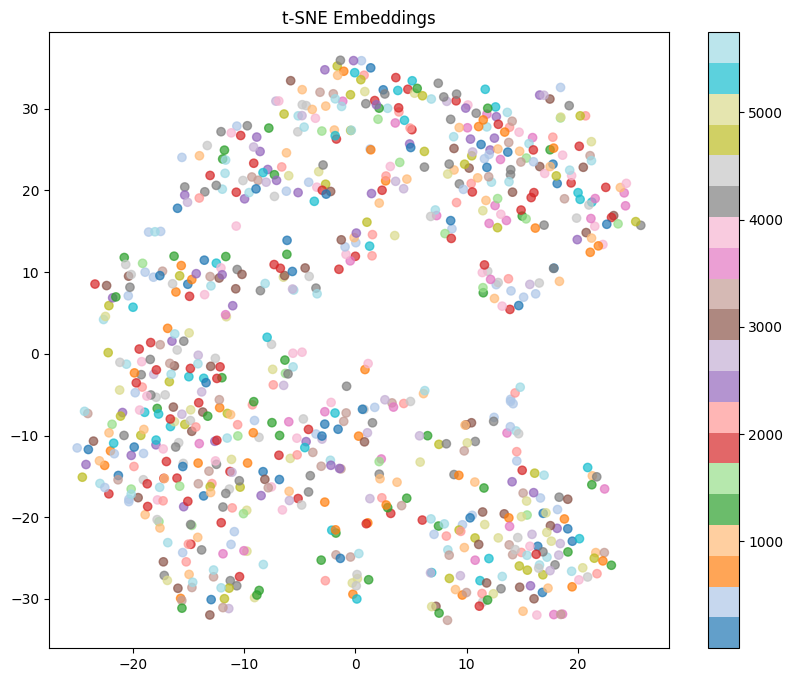


=== SimpleCNN + Contrastive ===
Epoch 1: loss 0.2928
Epoch 2: loss 0.2515
Epoch 3: loss 0.2457
→ AUC 0.535 | Acc 0.547 @ thr 0.92

=== SimpleCNN + Cosine ===
Epoch 1: loss 0.4996
Epoch 2: loss 0.4855
Epoch 3: loss 0.4907
→ AUC 0.544 | Acc 0.593 @ thr 0.79

=== SimpleCNN + InfoNCE ===
Epoch 1: loss 3.0535
Epoch 2: loss 2.9931
Epoch 3: loss 2.9387
→ AUC 0.568 | Acc 0.573 @ thr 0.89

=== SimpleCNN + Triplet ===
Epoch 1: loss 0.9917
Epoch 2: loss 0.9689
Epoch 3: loss 0.9399


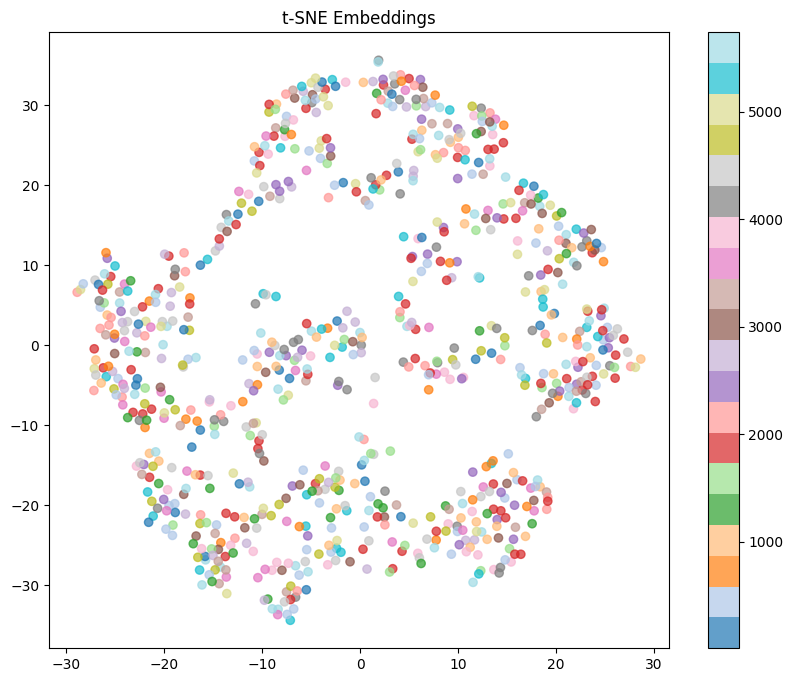


=== DeepCNN + Contrastive ===
Epoch 1: loss 0.3076
Epoch 2: loss 0.2392
Epoch 3: loss 0.2306
→ AUC 0.660 | Acc 0.633 @ thr 0.85

=== DeepCNN + Cosine ===
Epoch 1: loss 0.4832
Epoch 2: loss 0.4673
Epoch 3: loss 0.4650
→ AUC 0.607 | Acc 0.607 @ thr 0.70

=== DeepCNN + InfoNCE ===
Epoch 1: loss 3.3593
Epoch 2: loss 2.8571
Epoch 3: loss 2.7261
→ AUC 0.506 | Acc 0.533 @ thr 0.89

=== DeepCNN + Triplet ===
Epoch 1: loss 0.9026
Epoch 2: loss 0.6562
Epoch 3: loss 0.6505


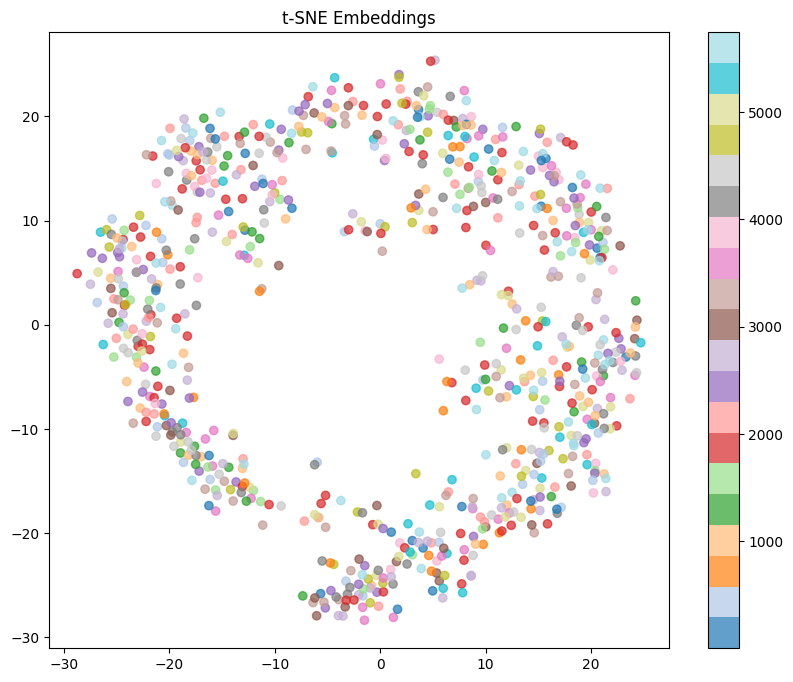


=== MobileNetV2 + Contrastive ===
Epoch 1: loss 0.2830
Epoch 2: loss 0.2138
Epoch 3: loss 0.1656
→ AUC 0.699 | Acc 0.667 @ thr 0.92

=== MobileNetV2 + Cosine ===
Epoch 1: loss 0.4976
Epoch 2: loss 0.3767
Epoch 3: loss 0.3036
→ AUC 0.738 | Acc 0.680 @ thr 0.54

=== MobileNetV2 + InfoNCE ===
Epoch 1: loss 3.1436
Epoch 2: loss 2.6861
Epoch 3: loss 2.4612
→ AUC 0.706 | Acc 0.660 @ thr 0.88

=== MobileNetV2 + Triplet ===
Epoch 1: loss 0.8686
Epoch 2: loss 0.5873


KeyboardInterrupt: 

In [44]:
# ====================================================================================
# CELL 11 – Run experiments
# ====================================================================================

architectures = {
    'MLP':        MLPBackbone,
    'SimpleCNN': SimpleCNN,
    'DeepCNN':    DeepCNN,
    'MobileNetV2':MobileNetBackbone
}

loss_funcs = {
    'Contrastive': ContrastiveLoss(),
    'Cosine':      lambda z1,z2,y: cos_emb_loss(z1,z2,(2*y-1)),
    'InfoNCE':     InfoNCELoss(),   # handled specially below
}

results = []

for arch_name, Arch in architectures.items():
    for loss_name, loss_fn in loss_funcs.items():
        print(f'\n=== {arch_name} + {loss_name} ===')
        model = Siamese(Arch().to(DEVICE))
        opt   = optim.Adam(model.parameters(), lr=1e-3)
        
        # pick train loop
        if loss_name=='InfoNCE':
            def epoch():  # custom loop – positive pairs stacked
                model.train(); running=0
                for x1,x2,_ in train_loader_pairs:
                    x = torch.cat([x1,x2],0).to(DEVICE)
                    opt.zero_grad()
                    loss = loss_fn(model.embed(x))
                    loss.backward(); opt.step()
                    running += loss.item()*x1.size(0)
                return running/len(train_loader_pairs.dataset)
            train_fn = epoch
        else:
            train_fn = lambda: train_epoch_siam(model,train_loader_pairs,
                                                loss_fn,opt)
        
        for ep in range(3):  # quick demo – raise to 10+ for real runs
            l = train_fn(); print(f'Epoch {ep+1}: loss {l:.4f}')
        auc, acc, th = evaluate(model,test_loader_pairs)
        print(f'→ AUC {auc:.3f} | Acc {acc:.3f} @ thr {th:.2f}')
        results.append(dict(Arch=arch_name,Loss=loss_name,
                            AUC=auc,Acc=acc,Threshold=th))
    
    # Triplet loss separately
    print(f'\n=== {arch_name} + Triplet ===')
    model = Siamese(Arch().to(DEVICE))
    opt   = optim.Adam(model.parameters(),1e-3)
    for ep in range(3):
        l = train_epoch_triplet(model,train_loader_trip,
                                TripletLoss(),opt)
        print(f'Epoch {ep+1}: loss {l:.4f}')
    auc, acc, th = evaluate(model,test_loader_pairs)
    results.append(dict(Arch=arch_name,Loss='Triplet',
                        AUC=auc,Acc=acc,Threshold=th))
    n_samples = min(800, len(test_base))
    plot_tsne(model, test_base, n_samples)
    plt.show()


In [45]:
# ====================================================================================
# CELL 12 – Results table & heatmaps
# ====================================================================================

df = pd.DataFrame(results).round(3)
print(df)

plt.figure(figsize=(10,4))
pivot_auc = df.pivot('Arch','Loss','AUC')
sns.heatmap(pivot_auc, annot=True, cmap='YlOrRd', fmt='.3f')
plt.title('AUC Heatmap'); plt.show()

pivot_acc = df.pivot('Arch','Loss','Acc')
sns.heatmap(pivot_acc, annot=True, cmap='YlGnBu', fmt='.3f')
plt.title('Accuracy Heatmap'); plt.show()

df.to_csv('siamese_arch_loss_results.csv', index=False)
print('Saved results to siamese_arch_loss_results.csv')


           Arch         Loss    AUC    Acc  Threshold
0           MLP  Contrastive  0.529  0.533      0.970
1           MLP       Cosine  0.558  0.567      0.437
2           MLP      InfoNCE  0.567  0.600      0.719
3           MLP      Triplet  0.552  0.567     -0.055
4     SimpleCNN  Contrastive  0.535  0.547      0.920
5     SimpleCNN       Cosine  0.544  0.593      0.789
6     SimpleCNN      InfoNCE  0.568  0.573      0.889
7     SimpleCNN      Triplet  0.602  0.607      0.608
8       DeepCNN  Contrastive  0.660  0.633      0.849
9       DeepCNN       Cosine  0.607  0.607      0.698
10      DeepCNN      InfoNCE  0.506  0.533      0.889
11      DeepCNN      Triplet  0.679  0.647     -0.166
12  MobileNetV2  Contrastive  0.699  0.667      0.920
13  MobileNetV2       Cosine  0.738  0.680      0.538
14  MobileNetV2      InfoNCE  0.706  0.660      0.879


TypeError: DataFrame.pivot() takes 1 positional argument but 4 were given

<Figure size 1000x400 with 0 Axes>

In [46]:
from sklearn.manifold import TSNE

def plot_tsne(model, dataset, n_samples=500):
    model.eval()
    images, labels = [], []

    for img, label in dataset:
        images.append(img)
        labels.append(label)
        if len(images) >= n_samples:
            break

    images = torch.stack(images).to(DEVICE)
    embeddings = model.embed(images).detach().cpu().numpy()

    tsne = TSNE(n_components=2, init='random', learning_rate='auto')
    reduced = tsne.fit_transform(embeddings)
    labels = np.array(labels)

    plt.figure(figsize=(8, 6))
    for label in np.unique(labels):
        idx = labels == label
        plt.scatter(reduced[idx, 0], reduced[idx, 1], label=label, alpha=0.6)
    plt.title("t-SNE Visualization of Embedding Space")
    plt.legend()
    plt.show()


In [47]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

def show_sample_results(model, dataloader, device, count=8):
    model.eval()
    images = []
    labels = []
    preds = []
    sims = []

    # Collect a batch
    with torch.no_grad():
        for img1, img2, label in dataloader:
            img1, img2 = img1.to(device), img2.to(device)
            z1, z2 = model(img1, img2)
            sim = F.cosine_similarity(z1, z2)
            pred = (sim > 0.5).long()
            images.extend(list(zip(img1.cpu(), img2.cpu())))
            labels.extend(label.cpu().numpy())
            preds.extend(pred.cpu().numpy())
            sims.extend(sim.cpu().numpy())
            if len(images) >= count:
                break

    plt.figure(figsize=(16, 3))
    for i in range(min(count, len(images))):
        plt.subplot(2, count // 2, i + 1)
        img1, img2 = images[i]
        # Merge side by side for visualization
        combined = torch.cat([img1, img2], -1)  # shape [3, H, 2*W]
        img_disp = combined.permute(1, 2, 0).numpy()
        img_disp = (img_disp - img_disp.min()) / (img_disp.max() - img_disp.min())
        plt.imshow(img_disp)
        title = f"GT: {int(labels[i])} | Pred: {int(preds[i])}\nSim: {sims[i]:.2f}"
        plt.title(title, color=('green' if int(labels[i]) == int(preds[i]) else 'red'), fontsize=10)
        plt.axis('off')
    plt.tight_layout()
    plt.show()


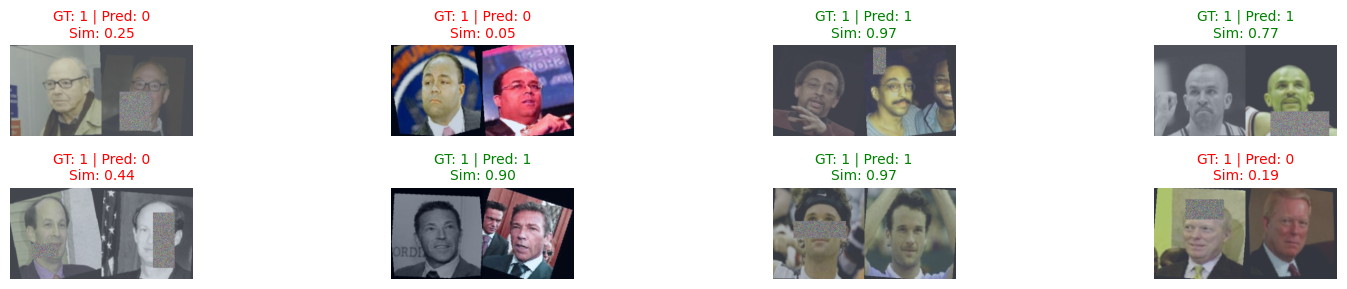

In [48]:
# Pass your trained model and a DataLoader
show_sample_results(model, test_loader_pairs, device=DEVICE, count=8)
